In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
#use_cuda = torch.cuda.is_available()
device = torch.device("cuda")

In [2]:
train=pd.read_csv("train_total.csv",index_col=False)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65628 entries, 0 to 65627
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Unnamed: 0                    65628 non-null  int64
 1   countryName                   65628 non-null  int64
 2   eprtrSectorName               65628 non-null  int64
 3   EPRTRAnnexIMainActivityLabel  65628 non-null  int64
 4   FacilityInspireID             65628 non-null  int64
 5   facilityName                  65628 non-null  int64
 6   City                          65628 non-null  int64
 7   targetRelease                 65628 non-null  int64
 8   pollutant                     65628 non-null  int64
 9   reportingYear                 65628 non-null  int64
 10  MONTH                         65628 non-null  int64
 11  DAY                           65628 non-null  int64
 12  CONTINENT                     65628 non-null  int64
 13  max_wind_speed                6

In [3]:
pca_3=['countryName','EPRTRAnnexIMainActivityLabel','FacilityInspireID','City',
       'MONTH','max_wind_speed', 'avg_wind_speed', 
       'min_wind_speed','max_temp','avg_temp', 'min_temp','DAY WITH FOGS', 'REPORTER NAME']
pca_4=['countryName','eprtrSectorName','EPRTRAnnexIMainActivityLabel','FacilityInspireID','City',
       'MONTH','max_wind_speed', 'avg_wind_speed', 
       'min_wind_speed','max_temp','avg_temp', 'min_temp','DAY WITH FOGS', 'REPORTER NAME','CITY ID']
train_labels=['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName', 'City', 'targetRelease',
        'reportingYear', 'MONTH', 'DAY', 'CONTINENT',
       'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 'max_temp',
       'avg_temp', 'min_temp', 'DAY WITH FOGS', 'REPORTER NAME', 'CITY ID']

x=train[train_labels]#.values
y=train['pollutant']#.values#.reshape((65628,1))
x.shape

(65628, 20)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0,test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=0,test_size=0.5)

In [5]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x_train, y_train)

In [6]:
print(sorted(Counter(y_test).items()))

[(0, 4671), (1, 3282), (2, 5173)]


In [7]:
f=10 # no. of batches #15

train_batch = np.array_split(X_resampled, f) 
label_batch = np.array_split(y_resampled, f) 

val_batch = np.array_split(x_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(x_test, f)
test_label_batch = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)

for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
for i in range(len(test_label_batch)):
    test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
    

    
print("Batch size:", len(train_batch[0]))

Batch size: 4699


In [8]:
class Regressor(nn.Module):#87%
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(20, 22)
        self.fc2 = nn.Linear(22, 24)
        self.fc3 = nn.Linear(24, 24)
        self.fc4 = nn.Linear(24, 24)
        self.fc5 = nn.Linear(24, 24)
        self.fc6 = nn.Linear(24, 8)
        self.fc7 = nn.Linear(8, 4)
        self.fc8 = nn.Linear(4, 1)
       
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))

        return x
    
model = Regressor()
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001) # 0.015 87
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.01, patience=15) 
total_epochs=0

In [9]:
epochs = 600
total_epochs+=epochs

for e in tnrange(epochs):
    
    model.train()
    train_loss = 0
    val_loss_1=0
    val_loss_sum = 0
    
    for i in range(len(train_batch)):
        
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
        
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_sum/len(val_batch))    
    val_losses.append(val_loss_sum/len(val_batch))    
    train_losses.append(train_loss/len(train_batch))   

C:\Users\ivanl\AppData\Local\Temp/ipykernel_25192/1894740975.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for e in tnrange(epochs):


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch : 0 train_loss : 8.489188170433044 Val loss:  4.3293256199359895
Epoch : 1 train_loss : 1.507488054037094 Val loss:  1.6475506556034087
Epoch : 2 train_loss : 1.527537649869919 Val loss:  1.6774366176128388
Epoch : 3 train_loss : 1.5281722843647003 Val loss:  1.6775509500503538
Epoch : 4 train_loss : 1.5206172943115235 Val loss:  1.6690640223026274
Epoch : 5 train_loss : 1.508497416973114 Val loss:  1.6545440697669982
Epoch : 6 train_loss : 1.4925074100494384 Val loss:  1.6342644536495208
Epoch : 7 train_loss : 1.4716095447540283 Val loss:  1.6067142474651337
Epoch : 8 train_loss : 1.4446345031261445 Val loss:  1.57348397731781
Epoch : 9 train_loss : 1.41428085565567 Val loss:  1.5369290030002594
Epoch : 10 train_loss : 1.381185734272003 Val loss:  1.4989328145980836
Epoch : 11 train_loss : 1.346532392501831 Val loss:  1.4578889214992523
Epoch : 12 train_loss : 1.309250634908676 Val loss:  1.4158124423027039
Epoch : 13 train_loss : 1.2714111387729645 Val loss:  1.3752731013298036

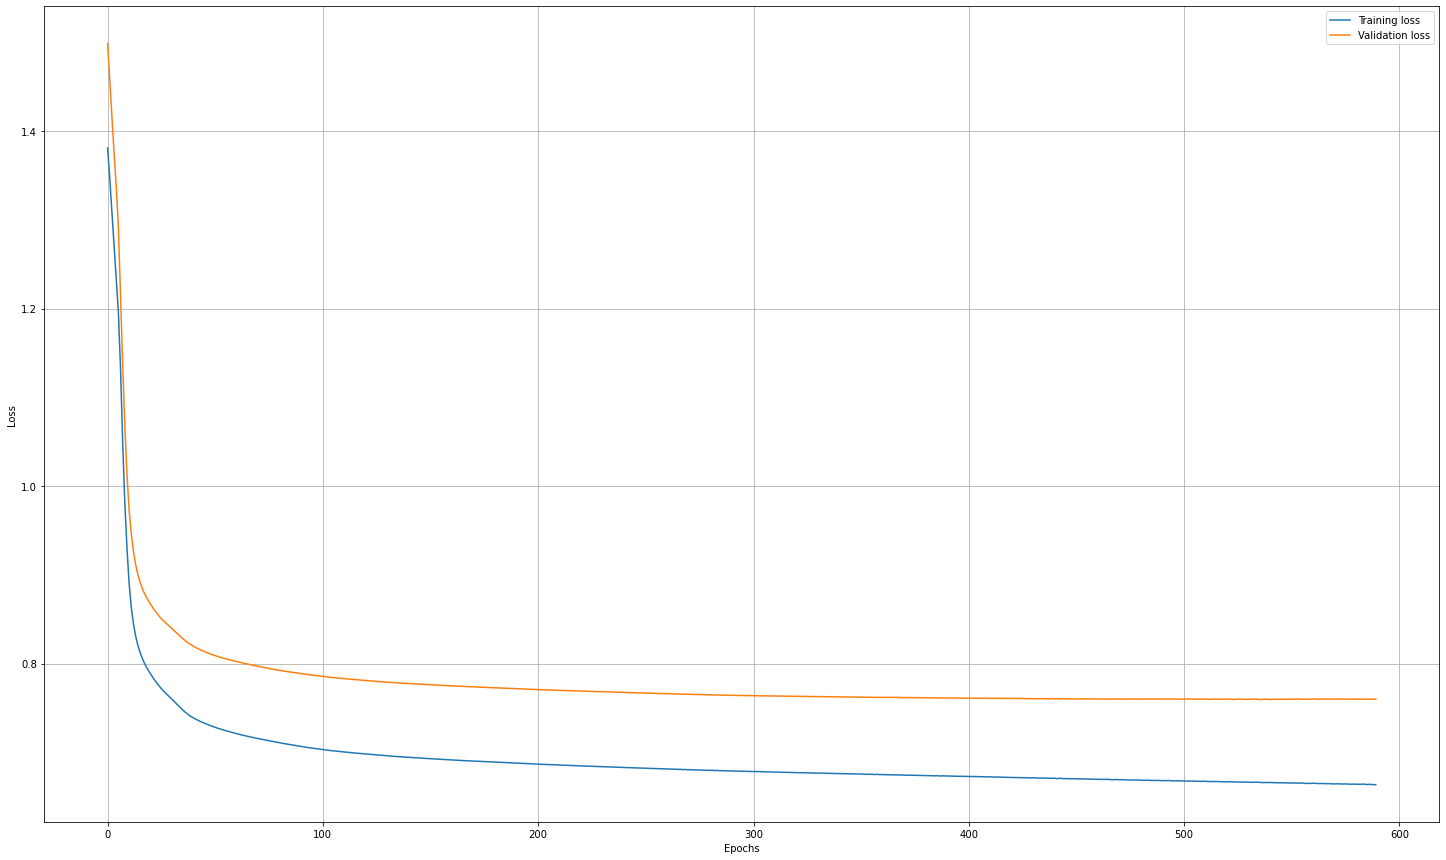

In [10]:

frm=10 # does not 
plt.figure(figsize=(25,15))
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
#ax = plt.gca()
#ax.set_ylim([0, 2])

In [11]:
correct=0
i=0
y_pred=[]
with torch.no_grad():
    for batch in test_batch :
        for j in range(len(batch)):
            x = model(batch[j])
            #print(round(x.item()))
            y_pred.append(round(x.item()))
#print(y_pred)

print(classification_report(y_test, y_pred))#, labels=np.unique(y_pred)))

              precision    recall  f1-score   support

           0       0.55      0.00      0.00      4671
           1       0.25      0.99      0.40      3282
           2       0.47      0.01      0.01      5173
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.25     13126
   macro avg       0.25      0.20      0.08     13126
weighted avg       0.44      0.25      0.11     13126



c:\ProgramData\Miniconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Miniconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Miniconda3\envs\tfg\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
